In [1]:
import requests
import time

import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import re
import glob
import random
import seaborn as sns


from IPython.display import clear_output

# http://www.nltk.org/howto/wordnet.html

from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
import sklearn
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression

from scipy import stats
from scipy.stats import spearmanr
from scipy.stats.stats import pearsonr


from nltk.wsd import lesk

## Load Data

In [5]:
test_dir = 'C:\\Users\\Phil\\Sync\\entity-recognition-datasets-master\\sentiment\\Data\\IMDB Reviews\\IMDB Data\\test'
train_dir = 'C:\\Users\\Phil\\Sync\\entity-recognition-datasets-master\\sentiment\\Data\\IMDB Reviews\\IMDB Data\\train'

# Alternatively written as a function for importing from different directory sources
def IMDB_to_csv( directory ):    
    data = pd.DataFrame()
    
    for filename in glob.glob(str(directory)+'\\neg\\*.txt'):
        with open(filename, 'r',  encoding="utf8") as f:
            content = f.readlines()
            content_table = pd.DataFrame({'id':filename.split('_')[0].split('\\')[-1],'rating':filename.split('_')[1].split('.')[0],'pol':'neg', 'text':content})
        data = data.append(content_table)
        
    for filename in glob.glob(str(directory)+'\\pos\\*.txt'):
        with open(filename, 'r',  encoding="utf8") as f:
            content = f.readlines()
            content_table = pd.DataFrame({'id':filename.split('_')[0].split('\\')[-1],'rating':filename.split('_')[1].split('.')[0],'pol':'pos', 'text':content})
        data = data.append(content_table)
    data = data.sort_values(['pol','id'])
    data = data.reset_index(drop=True)
    #data['rating_norm'] = (data['rating'] - data['rating'].min())/( data['rating'].max() - data['rating'].min() )

    return(data)



In [6]:
IMDB_train = IMDB_to_csv(train_dir)
IMDB_train['pol_id'] = np.where(IMDB_train['pol']=='neg',-1,
                        np.where(IMDB_train['pol']=='pos',1,0))

In [15]:
IMDB_train.head()

,id,rating,pol,text
0,0,3,neg,Story of a man who has unnatural feelings for ...
1,1,1,neg,Robert DeNiro plays the most unbelievably inte...
2,10,2,neg,"This film had a lot of promise, and the plot w..."
3,100,3,neg,OK its not the best film I've ever seen but at...
4,1000,4,neg,"The plot for Descent, if it actually can be ca..."


In [127]:
IMDB_test = IMDB_to_csv(test_dir)
IMDB_test['pol_id'] = np.where(IMDB_test['pol']=='neg',-1,
                        np.where(IMDB_test['pol']=='pos',1,0))

In [16]:
IMDB_test.head()

,id,rating,pol,text
0,0,2,neg,Once again Mr. Costner has dragged out a movie...
1,1,3,neg,This is a pale imitation of 'Officer and a Gen...
2,10,3,neg,"Years ago, when DARLING LILI played on TV, it ..."
3,100,4,neg,I was looking forward to this movie. Trustwort...
4,1000,3,neg,"First of all, I would like to say that I am a ..."


In [6]:
rt_train_path = 'C:\\Users\\Phil\\Sync\\entity-recognition-datasets-master\\sentiment\\Data\\RT_Sentiment\\train.tsv'
rt_train_data = pd.read_csv(rt_train_path,header=0,delimiter="\t",quoting=3)
rt_train_data['pol'] = np.where(rt_train_data['Sentiment']==3,"neut", np.where(rt_train_data['Sentiment']<3,"neg", np.where(rt_train_data['Sentiment']>3,"pos","")))
# Remove any neutral classified phrases
rt_train_data = rt_train_data[rt_train_data['pol']!="neut"]
rt_train_data = rt_train_data[rt_train_data['pol']!=""]

rt_train_data = rt_train_data.reset_index(drop=True)
#rt_test_path = 'E:\\Documents\\Text Data\\rottentomatoes\\test.tsv'
#rt_test_data = pd.read_csv(rt_test_path,header=0,delimiter="\t",quoting=3)



In [100]:
count_list = pd.DataFrame()
for i in range(0,len(rt_train_data)):
    count = pd.DataFrame({'count':len(rt_train_data['Phrase'][i].split())},index=[i])
    count_list = count_list.append(count)
count_list = count_list.reset_index(drop=True)
rt_train_data['word_count'] = count_list['count']

In [103]:
rt_train_data_2 = pd.DataFrame()
for i in range(1,max(rt_train_data['SentenceId'])):
    #Some sentence ids are not used and so we skip these
    if (len(rt_train_data[rt_train_data['SentenceId'] == i])==0):
        continue
    else:
        rt_train_data_2 = rt_train_data_2.append(rt_train_data[rt_train_data['SentenceId'] == i].sort_values('word_count', ascending=False).reset_index(drop=True).iloc[0,:])
rt_train_data_2 = rt_train_data_2.reset_index(drop=True)
# rename column from phrase to text for clarity
rt_train_data_2.columns = ['text', 'textId', 'SentenceId', 'Sentiment', 'pol', 'word_count']

In [104]:
rt_train_data_2['pol_id'] = np.where(rt_train_data_2['pol']=='neg',-1,
                        np.where(rt_train_data_2['pol']=='pos',1,0))
rt_train_data_2.head()

,text,textId,SentenceId,Sentiment,pol,word_count,pol_id
0,A series of escapades demonstrating the adage ...,1.0,1.0,1.0,neg,37.0,-1
1,"This quiet , introspective and entertaining in...",64.0,2.0,4.0,pos,11.0,1
2,"Even fans of Ismail Merchant 's work , I suspe...",82.0,3.0,1.0,neg,21.0,-1
3,A positively thrilling combination of ethnogra...,118.0,4.0,4.0,pos,25.0,1
4,Aggressive self-glorification and a manipulati...,157.0,5.0,1.0,neg,7.0,-1


In [128]:
twitter_train_path = 'C:\\Users\\Phil\\Sync\\entity-recognition-datasets-master\\sentiment\\Data\\twitter\\train.csv'
twitter_train = pd.read_csv(twitter_train_path, encoding="ISO-8859-1")
twitter_train.columns = ['ItemID','pol','text']
twitter_train['pol_id'] = np.where(twitter_train['pol']=='neg',-1,
                        np.where(twitter_train['pol']=='pos',1,0))
twitter_train.head()

C:\Users\Phil\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


,ItemID,pol,text,pol_id
0,1,0,is so sad for my APL frie...,0
1,2,0,I missed the New Moon trail...,0
2,3,1,omg its already 7:30 :O,0
3,4,0,.. Omgaga. Im sooo im gunna CRy. I'...,0
4,5,0,i think mi bf is cheating on me!!! ...,0


In [161]:
twitter_products_path = 'C:\\Users\\Phil\\Sync\\entity-recognition-datasets-master\\sentiment\\Data\\twitter\\judge-1377884607_tweet_product_company.csv'
twitter_products = pd.read_csv(twitter_products_path, encoding="ISO-8859-1")
twitter_products.columns = ['text','product','pol']
twitter_products['pol_id'] = np.where(twitter_products['pol']=='Negative emotion',-1,
                        np.where(twitter_products['pol']=='Positive emotion',1,0))
twitter_products.head()

,text,product,pol,pol_id
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,-1
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,1
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,1
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,-1
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,1


In [165]:
finance_messages_path = 'C:\\Users\\Phil\\Sync\\entity-recognition-datasets-master\\sentiment\\Data\\finance\\EnglishGS.csv'
finance_messages = pd.read_csv(finance_messages_path)
finance_messages.columns = ['unique_id','text','pol','type','id']

finance_messages['pol_id'] = np.where(finance_messages['pol']<0,-1,
                        np.where(finance_messages['pol']>0,1,0))
finance_messages.head()

,unique_id,text,pol,type,id,pol_id
0,15092$ZSL,"$ZSL looking very weak, could be a good short ...",-0.614,stocktwits,5711044.0,-1
1,15274$ZNGA,$ZNGA http://stks.co/3rdu Looking for a test a...,0.248,stocktwits,8011704.0,1
2,15398$ZNGA,$ZNGA did they prerelease sh*tty earnings or s...,-0.310,stocktwits,7706929.0,-1
3,15415$ZNGA,#ContrarianAlert: Why Zynga Failed - http://st...,-0.361,stocktwits,9862989.0,-1
4,15939$ZNGA,"""@IfHeDiesHeDies: ""@Bullhorn334: $ZNGA shorts ...",0.366,stocktwits,11964100.0,1


In [167]:
finance_headlines_path = 'C:\\Users\\Phil\\Sync\\entity-recognition-datasets-master\\sentiment\\Data\\finance\\SSIX News headlines Gold Standard EN.csv'
finance_headlines = pd.read_csv(finance_headlines_path)
finance_headlines.columns = ['unique_id','company','company_fixed','text','pol','num_scores']

finance_headlines['pol_id'] = np.where(finance_headlines['pol']<0,-1,
                        np.where(finance_headlines['pol']>0,1,0))
finance_headlines.head()


,unique_id,company,company_fixed,text,pol,num_scores,pol_id
0,0_Cuadrilla,Cuadrilla,Cuadrilla,Cuadrilla files to delay application to frack ...,-0.416,3,-1
1,1_Royal Mail,Royal Mail,Royal Mail,Royal Mail chairman Donald Brydon set to step ...,-0.374,3,-1
2,10_EasyJet,EasyJet,EasyJet,UPDATE 2-EasyJet sees better first half on low...,0.778,3,1
3,100_Weir,Weir,Weir Group,Slump in Weir leads FTSE down from record high,-0.827,3,-1
4,1000_AstraZeneca,AstraZeneca,AstraZeneca,AstraZeneca wins FDA approval for key new lung...,0.549,3,1


## Apply TextBlob pre-trained Sentiment Analysis

In [10]:
from textblob import TextBlob


In [46]:
text = '''
The titular threat of The Blob has always struck me as the ultimate movie
monster: an insatiably hungry, amoeba-like mass able to penetrate
virtually any safeguard, capable of--as a doomed doctor chillingly
describes it--"assimilating flesh on contact.
Snide comparisons to gelatin be damned, it's a concept with the most
devastating of potential consequences, not unlike the grey goo scenario
proposed by technological theorists fearful of
artificial intelligence run rampant.
'''

blob = TextBlob(text)
                                      
for sentence in blob.sentences:
    print(sentence.sentiment.polarity)

0.06000000000000001
-0.34166666666666673


In [47]:
blob

TextBlob("
The titular threat of The Blob has always struck me as the ultimate movie
monster: an insatiably hungry, amoeba-like mass able to penetrate
virtually any safeguard, capable of--as a doomed doctor chillingly
describes it--"assimilating flesh on contact.
Snide comparisons to gelatin be damned, it's a concept with the most
devastating of potential consequences, not unlike the grey goo scenario
proposed by technological theorists fearful of
artificial intelligence run rampant.
")

In [67]:
def text_blob(data_column):
    output_labels = pd.DataFrame()
    for n,phrases in enumerate(data_column):
        blob = TextBlob(phrases)
        polarity = blob.sentiment.polarity
        
        if polarity > 0:
            label = 1
        elif polarity == 0:
            label = 0
        else:
            label = -1
        
        output_labels = output_labels.append(pd.DataFrame({'label':label},index=[n]))
        
    return(output_labels['label'])
            

In [51]:
IMDB_train['text'][0].split('.')

['Story of a man who has unnatural feelings for a pig',
 ' Starts out with a opening scene that is a terrific example of absurd comedy',
 " A formal orchestra audience is turned into an insane, violent mob by the crazy chantings of it's singers",
 ' Unfortunately it stays absurd the WHOLE time with no general narrative eventually making it just too off putting',
 ' Even those from the era should be turned off',
 ' The cryptic dialogue would make Shakespeare seem easy to a third grader',
 " On a technical level it's better than you might think with some good cinematography by future great Vilmos Zsigmond",
 ' Future stars Sally Kirkland and Frederic Forrest can be seen briefly',
 '']

In [64]:
for n,phrases in enumerate(IMDB_train['text'][0:1]):
    blob = TextBlob(phrases)
    phrase_sentence_pol = pd.DataFrame()
    print(blob.sentiment.polarity)

-0.07175925925925922


In [62]:
blob

TextBlob("Robert DeNiro plays the most unbelievably intelligent illiterate of all time. This movie is so wasteful of talent, it is truly disgusting. The script is unbelievable. The dialog is unbelievable. Jane Fonda's character is a caricature of herself, and not a funny one. The movie moves at a snail's pace, is photographed in an ill-advised manner, and is insufferably preachy. It also plugs in every cliche in the book. Swoozie Kurtz is excellent in a supporting role, but so what?<br /><br />Equally annoying is this new IMDB rule of requiring ten lines for every review. When a movie is this worthless, it doesn't require ten lines of text to let other readers know that it is a waste of time and tape. Avoid this movie.")

In [68]:
IMDB_train['text_blob'] = text_blob(IMDB_train['text'])
IMDB_train.head()

,id,rating,pol,text,text_blob,pol_id
0,0,3,neg,Story of a man who has unnatural feelings for ...,-1,-1
1,1,1,neg,Robert DeNiro plays the most unbelievably inte...,-1,-1
2,10,2,neg,"This film had a lot of promise, and the plot w...",-1,-1
3,100,3,neg,OK its not the best film I've ever seen but at...,1,-1
4,1000,4,neg,"The plot for Descent, if it actually can be ca...",-1,-1


In [69]:
IMDB_train['pol_id'] = np.where(IMDB_train['pol']=='neg',-1,
                        np.where(IMDB_train['pol']=='pos',1,0))
IMDB_train.head()

,id,rating,pol,text,text_blob,pol_id
0,0,3,neg,Story of a man who has unnatural feelings for ...,-1,-1
1,1,1,neg,Robert DeNiro plays the most unbelievably inte...,-1,-1
2,10,2,neg,"This film had a lot of promise, and the plot w...",-1,-1
3,100,3,neg,OK its not the best film I've ever seen but at...,1,-1
4,1000,4,neg,"The plot for Descent, if it actually can be ca...",-1,-1


In [70]:
precision_applied = sklearn.metrics.precision_score(IMDB_train['pol_id'],
                                                            IMDB_train['text_blob'], average='weighted')
recall_applied = sklearn.metrics.recall_score(IMDB_train['pol_id'],
                                                            IMDB_train['text_blob'], average='weighted')

F1_applied = 2 * (precision_applied * recall_applied) / (precision_applied + recall_applied)


C:\Users\Phil\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [71]:
F1_applied

0.7180046132278655

In [81]:
from textblob.sentiments import NaiveBayesAnalyzer
blob = TextBlob("neutral", analyzer=NaiveBayesAnalyzer())
blob.sentiment.classification

'pos'

In [89]:
def text_blob_NB(data_column):
    output_labels = pd.DataFrame()
    for n,phrases in enumerate(data_column):
        clear_output(wait=True)
        print("Completed:", np.round(n/len(data_column)*100),"%")
        blob = TextBlob(phrases,analyzer=NaiveBayesAnalyzer())
        polarity = blob.sentiment.classification
        
        if polarity == 'pos':
            label = 1
        elif polarity == 'neg':
            label = -1
        else:
            label = 0
        
        output_labels = output_labels.append(pd.DataFrame({'label':label},index=[n]))
        
    return(output_labels['label'])
            

In [91]:
t0 = time.time()
IMDB_train['text_blob'] = text_blob_NB(IMDB_train['text'][0:10])
t1 = time.time()

total = t1-t0

IMDB_train['pol_id'] = np.where(IMDB_train['pol']=='neg',-1,
                        np.where(IMDB_train['pol']=='pos',1,0))
precision_applied = sklearn.metrics.precision_score(IMDB_train['pol_id'],
                                                            IMDB_train['text_blob'], average='weighted')
recall_applied = sklearn.metrics.recall_score(IMDB_train['pol_id'],
                                                            IMDB_train['text_blob'], average='weighted')

F1_applied = 2 * (precision_applied * recall_applied) / (precision_applied + recall_applied)
F1_applied

Completed: 90.0 %


ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [92]:
total

46.915640115737915

### Apply to all datasets


In [169]:
def text_blob_2(data_column):

    output_labels = pd.DataFrame()
    for n,phrases in enumerate(data_column):
        blob = TextBlob(phrases)
        polarity = blob.sentiment.polarity

        if polarity > 0:
            label = 1
        elif polarity == 0:
            label = 0
        else:
            label = -1

        output_labels = output_labels.append(pd.DataFrame({'label':label},index=[n]))
    return(output_labels['label'])




In [ ]:
"""
    output_labels_NB = pd.DataFrame()
    for n,phrases in enumerate(data_column):
        blob = TextBlob(phrases,analyzer=NaiveBayesAnalyzer())
        polarity = blob.sentiment.classification

        if polarity == 'pos':
            label = 1
        elif polarity == 'neg':
            label = -1
        else:
            label = 0

        output_labels_NB = output_labels_NB.append(pd.DataFrame({'label':label},index=[n]))

    return(output_labels['label'],output_labels_NB['label'])
"""
"""


    precision_applied_NB = sklearn.metrics.precision_score(IMDB_train['pol_id'],
                                                                IMDB_train['text_blob_NB'], average='weighted')
    recall_applied_NB = sklearn.metrics.recall_score(IMDB_train['pol_id'],
                                                                IMDB_train['text_blob_NB'], average='weighted')

    F1_applied_NB = 2 * (precision_applied_NB * recall_applied_NB) / (precision_applied_NB + recall_applied_NB)
    
    
"""

In [171]:
datasets = [IMDB_train,IMDB_test,rt_train_data_2,twitter_products,finance_messages,finance_headlines]
dataset_names = ['IMDB_train','IMDB_test','rt_train_data_2','twitter_products','financial_messages','financial_headlines']
dataset_text_col = ['text','text','text','text','text','text']

output = pd.DataFrame()
for n,dataset in enumerate(datasets):
    print('Current Dataset:',dataset_names[n])
    datasets[n]['text_blob_def'] = text_blob_2(datasets[n][str(dataset_text_col[n])].astype(str))
    #dataset['text_blob_NB'] = text_blob_2(dataset[str(dataset_text_col[n])])[0]

    precision_applied = sklearn.metrics.precision_score(datasets[n]['pol_id'],
                                                                datasets[n]['text_blob_def'], average='weighted')
    recall_applied = sklearn.metrics.recall_score(datasets[n]['pol_id'],
                                                                datasets[n]['text_blob_def'], average='weighted')

    F1_applied = 2 * (precision_applied * recall_applied) / (precision_applied + recall_applied)
    
    
    
    
    output = output.append(pd.DataFrame({'dataset':dataset_names[n],
                                         'text_blob_def_prec':precision_applied,
                                         'text_blob_def_recall':recall_applied,
                                         'text_blob_def_F1':F1_applied
                                         }, index=[n]))

Current Dataset: IMDB_train


C:\Users\Phil\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Current Dataset: IMDB_test


C:\Users\Phil\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Current Dataset: rt_train_data_2


C:\Users\Phil\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Current Dataset: twitter_products
Current Dataset: financial_messages
Current Dataset: financial_headlines


In [172]:
output

,dataset,text_blob_def_prec,text_blob_def_recall,text_blob_def_F1
0,IMDB_train,0.754496,0.684880,0.718005
1,IMDB_test,0.760819,0.691320,0.724406
2,rt_train_data_2,0.787939,0.427141,0.553973
3,twitter_products,0.575329,0.486858,0.527409
4,financial_messages,0.646681,0.422336,0.510968
5,financial_headlines,0.689182,0.218557,0.331869


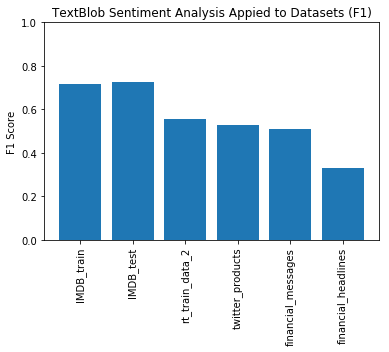

In [177]:
plt.bar(output['dataset'],output['text_blob_def_F1'])
plt.title("TextBlob Sentiment Analysis Appied to Datasets (F1)")
plt.xticks(rotation='vertical')
plt.ylim([0,1])
plt.ylabel("F1 Score")
plt.show()

In [146]:
def text_blob_2(data_column):

    output_labels = pd.DataFrame()
    for n,phrases in enumerate(data_column):
        blob = TextBlob(phrases)
        polarity = blob.sentiment.polarity

        if polarity > 0:
            label = 1
        elif polarity < 0:
            label = -1
        else:
            label = 0

        output_labels = output_labels.append(pd.DataFrame({'label':label},index=[n]))
        
    output_labels_NB = pd.DataFrame()
    for n,phrases in enumerate(data_column):
        clear_output(wait=True)
        print("Completed:", np.round(n/len(data_column),4)*100,"%")
        blob = TextBlob(phrases,analyzer=NaiveBayesAnalyzer())
        polarity = blob.sentiment.classification

        if polarity == 'pos':
            label = 1
        elif polarity == 'neg':
            label = -1
        else:
            label = 0

        output_labels_NB = output_labels_NB.append(pd.DataFrame({'label':label},index=[n]))

    return(output_labels['label'],output_labels_NB['label'])


In [149]:
datasets = [IMDB_train,IMDB_test,rt_train_data_2,twitter_train]
dataset_names = ['IMDB_train','IMDB_test','rt_train_data_2','twitter_train']
dataset_text_col = ['text','text','text','text']

output = pd.DataFrame()
for n,dataset in enumerate(datasets[1:2]):
    print('Current Dataset:',dataset_names[n])
    prediction = text_blob_2(datasets[n][str(dataset_text_col[n])])
    datasets[n]['text_blob_def'] = prediction[0]
    dataset['text_blob_NB'] = prediction[1]

    precision_applied = sklearn.metrics.precision_score(datasets[n]['pol_id'],
                                                                datasets[n]['text_blob_def'], average='weighted')
    recall_applied = sklearn.metrics.recall_score(datasets[n]['pol_id'],
                                                                datasets[n]['text_blob_def'], average='weighted')

    F1_applied = 2 * (precision_applied * recall_applied) / (precision_applied + recall_applied)
    
    precision_applied_NB = sklearn.metrics.precision_score(datasets[n]['pol_id'],
                                                                datasets[n]['text_blob_NB'], average='weighted')
    recall_applied_NB = sklearn.metrics.recall_score(datasets[n]['pol_id'],
                                                                datasets[n]['text_blob_NB'], average='weighted')

    F1_applied_NB = 2 * (precision_applied_NB * recall_applied_NB) / (precision_applied_NB + recall_applied_NB)
    
    
    
    
    output = output.append(pd.DataFrame({'dataset':dataset_names[n],
                                         'text_blob_def_prec':precision_applied,
                                         'text_blob_def_recall':recall_applied,
                                         'text_blob_def_F1':F1_applied,
                                         'text_blob_NB_prec':precision_applied_NB,
                                         'text_blob_NB_recall':recall_applied_NB,
                                         'text_blob_NB_F1':F1_applied_NB
                                         }, index=[n]))

Completed: 100.0 %


C:\Users\Phil\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [151]:
output

,dataset,text_blob_def_prec,text_blob_def_recall,text_blob_def_F1,text_blob_NB_prec,text_blob_NB_recall,text_blob_NB_F1
0,IMDB_train,0.754496,0.68488,0.718005,0.783703,0.734,0.758037


In [157]:
n


0

In [156]:
dataset.head()

,id,rating,pol,text,pol_id,text_blob_def,text_blob_NB
0,0,2,neg,Once again Mr. Costner has dragged out a movie...,-1,1,1
1,1,3,neg,This is a pale imitation of 'Officer and a Gen...,-1,1,-1
2,10,3,neg,"Years ago, when DARLING LILI played on TV, it ...",-1,1,-1
3,100,4,neg,I was looking forward to this movie. Trustwort...,-1,1,-1
4,1000,3,neg,"First of all, I would like to say that I am a ...",-1,1,-1
